# Alpha Model Improvements: Sector-Neutral Cross-Sectional Ridge

This notebook extends the baseline pipeline by making a single, defensible change to the alpha model:
fit the daily cross-sectional Ridge regression after removing sector effects.

Motivation:
- The baseline out-of-sample Ridge alpha model underperformed.
- A common failure mode of naive cross-sectional models is that it implicitly learns sector bets (or gets distorted by sector-wide moves).
- Rather than tuning parameters, we test one structural improvement: sector-neutralization inside the regression.

Goal:
- Demonstrate a controlled iteration that improves signal diagnostics (IC stability and exposure control),
  without relying on heavy hyperparameter tuning.

## 1. Imports and environment setup

We import the same project modules used in the baseline notebook and add the project root (`..`) to `sys.path`
so the notebook can import from `src/`.

In [1]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data_loader import EquityDataLoader, DataConfig
from src.factors import FactorCalculator, FactorConfig, zscore_cross_section
from src.alpha_model import AlphaModelOOSRidge, AlphaModelOOSRidgeSectorNeutral

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

## 2. Define the equity universe and sample period

We use the full S&P 500 universe, loaded from `data/universe/sp500.csv` (must contain a `Symbol` column).
Using a large liquid cross-section improves the stability of rolling factor estimates and daily cross-sectional
regressions.

In [2]:
sp500_path = ROOT / "data" / "universe" / "sp500.csv"
sp500_path.parent.mkdir(parents=True, exist_ok=True)

def load_sp500_tickers() -> list[str]:
    '''
    Load the S&P 500 constituent list from a local CSV file.

    Expected file: data/universe/sp500.csv
    Expected column: 'Symbol'
    '''
    if not sp500_path.exists():
        raise FileNotFoundError(
            f"Expected {sp500_path} to exist.\n"
            "Please download an S&P 500 constituents CSV (with a 'Symbol' column) "
            "and save it to this path."
        )

    df = pd.read_csv(sp500_path)

    if "Symbol" not in df.columns:
        raise ValueError(
            f"sp500.csv must contain a 'Symbol' column. Columns found: {list(df.columns)}"
        )

    symbols = (
        df["Symbol"]
        .astype(str)
        .str.strip()
        .str.replace(".", "-", regex=False)
        .dropna()
        .unique()
        .tolist()
    )
    return symbols

sp500_tickers = load_sp500_tickers()
len(sp500_tickers), sp500_tickers[:10]

(503, ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A'])

In [3]:
universe = sp500_tickers
start = "2010-01-01"
end = "2024-12-31"

## 3. Load adjusted close prices

We download and cache adjusted close prices from Yahoo Finance:
- Cached under `data/prices/raw/`
- Returned as a wide DataFrame (date x ticker)

In [4]:
data_cfg = DataConfig()
loader = EquityDataLoader(project_root=ROOT, config=data_cfg)

prices = loader.load_adjusted_close(
    tickers=universe,
    start=start,
    end=end,
    interval="1d",
    force_refresh=False,
)

prices.tail()

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: WBA"}}}

1 Failed download:
['WBA']: YFTzMissingError('possibly delisted; no timezone found')


[DataLoader] Skipping WBA: Downloaded empty DataFrame for ticker WBA.


,MMM,AOS,ABT,ABBV,ACN,ADBE,AMD,AES,AFL,A,APD,ABNB,AKAM,ALB,ARE,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,...,WRB,GWW,WAB,WMT,DIS,WBD,WM,WAT,WEC,WFC,WELL,WST,WDC,WY,WSM,WMB,WTW,WDAY,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-23,126.589973,67.177307,112.184288,172.363205,353.719879,446.739990,124.599998,12.304317,100.531624,133.516983,286.256195,134.520004,96.599998,87.650490,93.018967,207.570007,131.106903,57.384167,189.902512,193.870728,195.229950,49.940449,225.059998,9.183184,87.134323,...,57.798267,1072.735474,190.486176,89.675789,110.926964,10.44,200.811218,369.760010,91.717125,69.039757,123.454231,328.502686,46.352802,27.177324,183.727386,52.675449,310.858765,265.390015,87.261322,65.543053,116.122368,131.317734,390.649994,105.818138,162.125519
2024-12-24,127.944412,67.500648,112.625923,173.918808,356.539642,447.940002,126.290001,12.266631,101.020866,135.004929,288.664795,134.990005,96.910004,88.426765,93.517395,213.500000,132.009857,57.732777,191.756134,195.344940,196.803833,49.837914,229.050003,9.241613,88.300125,...,58.095131,1081.298828,193.182526,91.988411,112.082031,10.55,202.368073,373.149994,91.910545,70.067413,124.407509,331.692291,46.458221,27.351536,184.919266,53.211460,312.490295,269.040009,87.924866,66.017303,116.754807,132.436081,395.440002,106.293640,162.539993
2024-12-26,128.749207,67.500648,113.126434,173.145828,355.356537,450.160004,125.059998,12.097046,101.431854,134.737091,287.748169,135.320007,97.959999,87.601364,93.705467,215.500000,131.960251,57.761826,191.854187,194.836945,196.335663,49.980442,227.050003,9.212399,88.105827,...,58.599792,1073.022949,192.884033,92.097588,112.072083,10.62,202.013336,376.779999,91.746147,70.233810,124.210960,332.350159,46.465744,27.264429,184.820770,52.587742,314.309692,269.380005,88.449760,65.988274,117.071037,133.417099,396.850006,106.244102,163.349258
2024-12-27,127.767731,67.049927,112.851646,171.996033,351.166321,446.480011,125.190002,12.012254,101.157860,134.449417,285.534576,133.384995,96.970001,86.756302,92.492310,211.429993,130.948135,57.655304,190.069244,192.008011,193.287506,49.771404,223.750000,9.192922,87.552071,...,58.352406,1059.494141,191.033401,90.976021,111.076332,10.61,201.028015,374.600006,91.697800,69.597633,122.844917,332.140839,45.705246,27.090216,183.264420,52.568245,312.767151,266.239990,87.825829,65.949562,116.142136,132.661728,389.070007,105.867676,162.441315
2024-12-30,126.737213,66.648193,110.702377,170.247192,347.528290,445.799988,122.440002,11.918040,100.756676,133.338425,281.516968,131.809998,95.559998,84.643646,91.975067,206.580002,129.955872,57.451954,188.843307,190.493942,191.942764,49.486343,221.300003,9.095539,87.066322,...,57.907120,1048.819580,189.988678,89.894157,110.329514,10.51,199.303680,370.940002,91.107872,68.912521,122.766312,327.755096,44.892040,26.993431,183.717514,52.782650,309.731537,262.000000,85.003288,65.417229,114.906891,130.984192,383.850006,104.646461,160.112274


### Quick price diagnostics

With a large universe, plotting all price series is not informative. Instead:
- Plot a small sample of tickers as a sanity check.
- Plot the cross-sectional average price as an aggregate diagnostic.

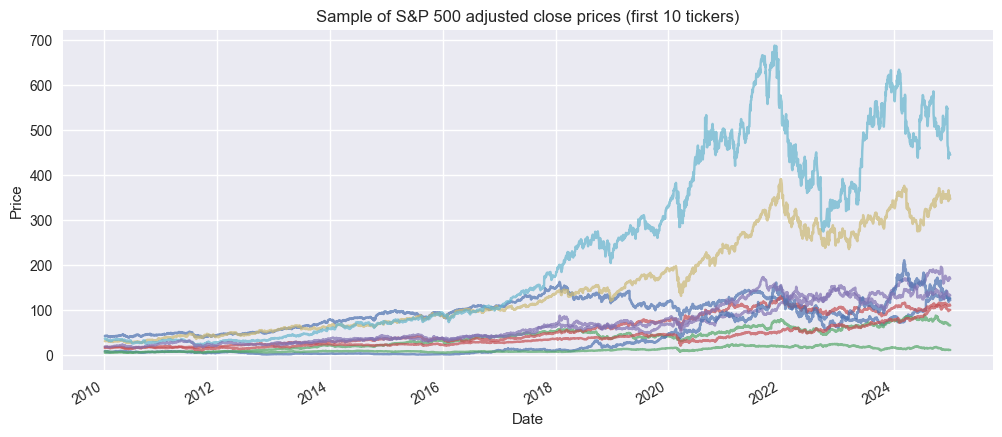

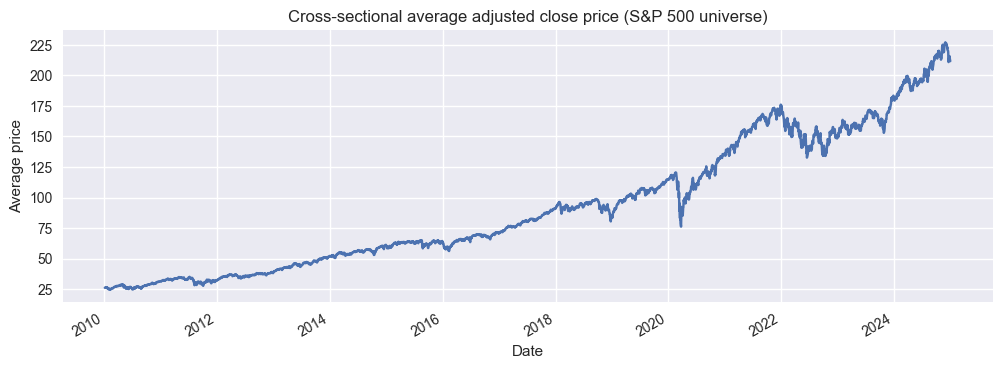

In [5]:
sample_cols = prices.columns[:10]
prices[sample_cols].plot(
    figsize=(12, 5),
    alpha=0.7,
    legend=False,
    title="Sample of S&P 500 adjusted close prices (first 10 tickers)",
)
plt.ylabel("Price")
plt.grid(True)
plt.show()

avg_price = prices.mean(axis=1)
avg_price.plot(
    figsize=(12, 4),
    title="Cross-sectional average adjusted close price (S&P 500 universe)",
)
plt.ylabel("Average price")
plt.grid(True)
plt.show()

## 4. Factor construction (price-based library)

We compute a set of purely price-based factors per stock and per date:
- Lagged returns (short-term reversal proxy)
- Multi-horizon momentum
- Realized volatility
- 5-day reversal
- Volatility-of-volatility
- Volatility-scaled momentum

Factors are later standardized cross-sectionally (z-scored) before being fed to the alpha models.

In [6]:
factor_cfg = FactorConfig(
    ret_lag=1,
    momentum_windows=[21, 63, 252],
    volatility_windows=[21, 63],
    include_short_term_reversal=True,
    reversal_window=5,
    include_vol_of_vol=True,
    vov_windows=[21, 63],
    include_vol_adj_momentum=True,
    vol_adj_mom_pairs=[(21, 21), (63, 63), (252, 63)],
)

factor_calc = FactorCalculator(factor_cfg)
factor_panel = factor_calc.build_factor_panel(prices)

factor_panel.head()

ret_1d  mom_21d  mom_63d  mom_252d  vol_21d  vol_63d  \
date       ticker                                                           
2010-01-05 A      -0.010862      NaN      NaN       NaN      NaN      NaN   
           ABT    -0.008079      NaN      NaN       NaN      NaN      NaN   
           ACGL   -0.003336      NaN      NaN       NaN      NaN      NaN   
           ACN     0.006180      NaN      NaN       NaN      NaN      NaN   
           ADBE    0.016446      NaN      NaN       NaN      NaN      NaN   

                   rev_5d  vov_21x21d  vov_63x63d  mom_21d_over_vol_21d  \
date       ticker                                                         
2010-01-05 A          NaN         NaN         NaN                   NaN   
           ABT        NaN         NaN         NaN                   NaN   
           ACGL       NaN         NaN         NaN                   NaN   
           ACN        NaN         NaN         NaN                   NaN   
           ADBE       NaN         NaN         NaN                   NaN   

                   mom_63d_over_vol_63d  mom_252d_over_vol_63d  
date       ticker                                               
2010-01-05 A                        NaN                    NaN  
           ABT                      NaN                    NaN  
           ACGL                     NaN                    NaN  
           ACN                      NaN                    NaN  
           ADBE                     NaN                    NaN

## 5. Cross-sectional z-scoring of factors

On each date, factors are z-scored across the cross-section of stocks. This standardizes factor scales and
supports regression and combination across heterogeneous factor families.

In [7]:
zpanel = zscore_cross_section(factor_panel)
zpanel.head()

ret_1d  mom_21d  mom_63d  mom_252d  vol_21d  vol_63d  \
date       ticker                                                           
2010-01-05 A      -0.764773      NaN      NaN       NaN      NaN      NaN   
           ABT    -0.617510      NaN      NaN       NaN      NaN      NaN   
           ACGL   -0.366528      NaN      NaN       NaN      NaN      NaN   
           ACN     0.136968      NaN      NaN       NaN      NaN      NaN   
           ADBE    0.680153      NaN      NaN       NaN      NaN      NaN   

                   rev_5d  vov_21x21d  vov_63x63d  mom_21d_over_vol_21d  \
date       ticker                                                         
2010-01-05 A          NaN         NaN         NaN                   NaN   
           ABT        NaN         NaN         NaN                   NaN   
           ACGL       NaN         NaN         NaN                   NaN   
           ACN        NaN         NaN         NaN                   NaN   
           ADBE       NaN         NaN         NaN                   NaN   

                   mom_63d_over_vol_63d  mom_252d_over_vol_63d  
date       ticker                                               
2010-01-05 A                        NaN                    NaN  
           ABT                      NaN                    NaN  
           ACGL                     NaN                    NaN  
           ACN                      NaN                    NaN  
           ADBE                     NaN                    NaN

## Sector metadata (required for sector-neutral regression)

We load a ticker → sector mapping from `data/universe/sp500.csv`. The sector labels are used by the
sector-neutral alpha model to remove sector-wide effects inside each daily cross-section during training and
prediction. This keeps the model focused on within-sector stock selection rather than learning sector bets.

In [8]:
sp500_meta = pd.read_csv(ROOT / "data" / "universe" / "sp500.csv")

sector_col_candidates = ["Sector", "GICS Sector"]
sector_col = None
for c in sector_col_candidates:
    if c in sp500_meta.columns:
        sector_col = c
        break

if sector_col is None:
    raise ValueError(
        "sp500.csv must contain a 'Sector' or 'GICS Sector' column.\n"
        f"Columns found: {list(sp500_meta.columns)}"
    )

sp500_meta["Symbol"] = (
    sp500_meta["Symbol"].astype(str).str.strip().str.replace(".", "-", regex=False)
)

sector_map = sp500_meta.set_index("Symbol")[sector_col].astype(str).str.strip()
sector_map.head()

Symbol
MMM                Industrials
AOS                Industrials
ABT                Health Care
ABBV               Health Care
ACN     Information Technology
Name: GICS Sector, dtype: object

## 6. Baseline OOS Ridge vs Sector-Neutral OOS Ridge

We fit two models with identical hyperparameters:
- Baseline Ridge OOS regression (no explicit sector handling)
- Sector-neutral Ridge OOS regression (demeans within sector inside each daily cross-section)

We compare:
- Daily information coefficient (IC)
- Cumulative IC curves
- Mean IC and IC t-stat

In [9]:
factor_columns = list(zpanel.columns)

alpha_model_base = AlphaModelOOSRidge(
    factor_columns=factor_columns,
    lookback_days=60,
    min_history_days=40,
    min_stocks=50,
    ridge_lambda=10.0,
)

res_base = alpha_model_base.fit(zpanel, prices)
pred_base = res_base["predictions"].rename("pred_base")

ic_base = res_base["ic"]
ic_base = ic_base["ic"] if isinstance(ic_base, pd.DataFrame) else ic_base
ic_base = ic_base.dropna().rename("IC_base")

ic_base.describe()

count    3155.000000
mean       -0.006776
std         0.170575
min        -0.637409
25%        -0.109707
50%        -0.003244
75%         0.095517
max         0.627275
Name: IC_base, dtype: float64

In [10]:
alpha_model_sn = AlphaModelOOSRidgeSectorNeutral(
    factor_columns=factor_columns,
    sector_map=sector_map,
    lookback_days=60,
    min_history_days=40,
    min_stocks=50,
    ridge_lambda=10.0,
    min_names_per_sector=3,
    ic_on_sector_demeaned_returns=False,
)

res_sn = alpha_model_sn.fit(zpanel, prices)
pred_sn = res_sn["predictions"].rename("pred_sector_neutral")

ic_sn = res_sn["ic"]
ic_sn = ic_sn["ic"] if isinstance(ic_sn, pd.DataFrame) else ic_sn
ic_sn = ic_sn.dropna().rename("IC_sector_neutral")

ic_sn.describe()

count    3155.000000
mean       -0.002112
std         0.134761
min        -0.546856
25%        -0.078730
50%        -0.000379
75%         0.079939
max         0.487178
Name: IC_sector_neutral, dtype: float64

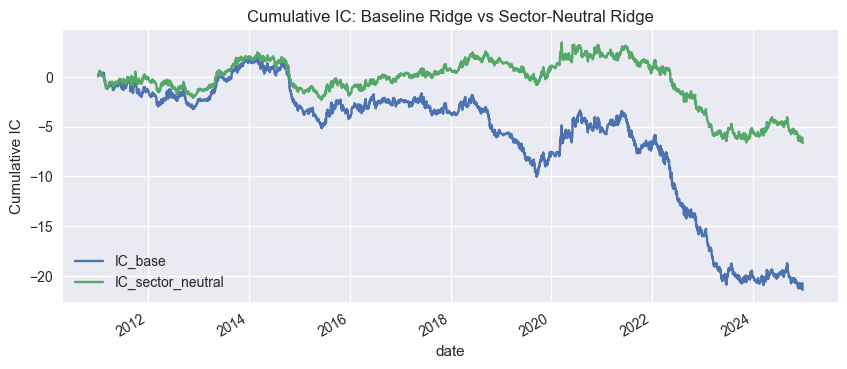

,BaselineRidge,SectorNeutralRidge
MeanIC,-0.006776,-0.002112
ICtStat,-2.231784,-0.880429
N,3155.000000,3155.000000


In [11]:
ic_compare = pd.concat([ic_base, ic_sn], axis=1, join="inner").dropna()

ax = ic_compare.cumsum().plot(figsize=(10, 4))
ax.set_title("Cumulative IC: Baseline Ridge vs Sector-Neutral Ridge")
ax.set_ylabel("Cumulative IC")
ax.grid(True)
plt.show()

def ic_summary(s: pd.Series) -> pd.Series:
    s = s.dropna()
    mu = s.mean()
    sig = s.std(ddof=0)
    t = mu / (sig + 1e-12) * np.sqrt(len(s))
    return pd.Series({"MeanIC": mu, "ICtStat": t, "N": len(s)})

pd.DataFrame(
    {
        "BaselineRidge": ic_summary(ic_compare["IC_base"]),
        "SectorNeutralRidge": ic_summary(ic_compare["IC_sector_neutral"]),
    }
)

## 7. Interpreting the result

The sector-neutral model removes sector-level means within each daily cross-section during both training
and prediction. This reduces the likelihood that the regression is implicitly learning sector bets or being
distorted by sector-wide return shocks.

Empirically, this modification produces a **material reduction in negative bias and volatility** in the
out-of-sample information coefficient (IC). While the sector-neutral model does not generate positive
alpha on its own, it is **better conditioned** than the baseline Ridge model:

- The mean IC moves closer to zero.
- The IC time series exhibits lower variance and smaller drawdowns.
- Statistical significance of negative predictability is substantially reduced.

This outcome is consistent with a model that is no longer dominated by unintended sector exposures,
and therefore represents a **structural improvement in signal quality**, rather than overfitting or
parameter tuning.

The baseline model is retained throughout to allow for direct, transparent comparison.